понятное [видео](https://www.youtube.com/watch?v=bNb2fEVKeEo) со стенфордского курса, из [материалов](https://cs231n.github.io/convolutional-networks) по которому взяты иллюстрации.

Датасет из [курса](https://github.com/DanAnastasyev/DeepNLP-Course/blob/master/Week%2004/Week_04_Convolutional_Neural_Networks.ipynb) Даниила Анастасьева.

Использовались [материалы](https://github.com/mannefedov/hse_ml_m1/blob/master/7_cnn/cnn.ipynb) из курса Михаила Нефедова.

# Сверточный слой




Желтое - фильтр (= filter,kernel).

Зеленое - входные данные, например, изображение.

Розовое - карта активации (activation map).

Каждый элемент в розовой матрице - результат поэлементного умножения фильтра на числа из области на входных данных.
Обучаемые параметры - элементы фильтра.

![Conv](https://image.ibb.co/e6t8ZK/Convolution.gif)



Чтобы не терять размер матрицы используется паддинг.

![padding](https://3deep.ru/wp-content/uploads/2020/01/keras_conv2d_padding.gif)

from https://3deep.ru/machinelearning/

# Pooling слой  (не обучается)

![Pool](https://cs231n.github.io/assets/cnn/pool.jpeg)
![maxpool](https://cs231n.github.io/assets/cnn/maxpool.jpeg)

# Свертки для текстов устроены немного по-другому. В них на одну размерность меньше.

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png)

From [Character-Aware Neural Language Models](https://arxiv.org/pdf/1508.06615.pdf)

# CNN для обработки текстов



In [1]:
#!pip install torchmetrics

In [2]:
#!pip install ipdb

In [13]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb
from tqdm import tqdm

### Слова



### Скачивание и подготовка данных

Давайте не будем заново, мы их уже предобработали и в файл сохранили

In [14]:
train_data =  pd.read_csv('train.csv')
val_data = pd.read_csv('val.csv')

In [15]:
train_data[train_data.type == 1].shape[0] / train_data.shape[0]

0.5079447203826343

In [16]:
train_data.head(50)

,Unnamed: 0,text,type,clean_texts
0,0,"эх, ехать на репу пора((\nЗавтра уже выступление.",0,"эх , ехать на репа пора ( ( завтра уже выступл..."
1,1,"Аллергия вышла,из-за этих тупых мандарин(((((((",0,"аллергия выйти , из - за этот тупой мандарин (..."
2,2,@KompaundTone550 @tatysho власть всегда была б...,1,"власть всегда была , просто теперь об знать ве..."
3,3,"@Alinockaa А хрен, я гулящая пока, потом насиж...",1,"а хрен , я пока , потом дома : dd но сегодня я..."
4,4,"RT @vik_vans: блин, слушала первый мини-альбом...",0,"rt @vik_vans : блин , слушать первый мини - ал..."
5,5,Как же не сделать фото на айфон в зеркале:-D h...,1,как же не сделать фото на айфон в
6,6,Заебись погулял... Мама пуховик постирала ;((,0,заебись погулял ... мама пуховик постирать ; ( (
7,7,#HappyBirthdayLouisfromCIS Почему я мало пиш...,0,# почему я мало писать в тви ; ( ( ( (
8,8,@cobyisnotalone ладно :(\nмне через полтора ча...,0,ладно :( мне через полтора час только
9,9,"@DashaSone вот да, это было бы идеально! Хочу ...",1,"вот да , это было бы идеальный ! хотеть все пр..."


Почему мы можем трогать только train_data? Потому что иначе может попасть что-нибудь из теста. Вероятно, будет не очень заментно, но исключать возможность не стоит, и на уровне слов она больше, чем на уровне символов

In [17]:
vocab = Counter()
for text in tqdm(train_data['clean_texts']):
    vocab.update(str(text).split(' '))
print('всего уникальных слов:', len(vocab))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173952/173952 [00:00<00:00, 343560.41it/s]

всего уникальных слов: 18112


In [18]:
vocab

Counter({'эх': 697,
         ',': 143900,
         'ехать': 1089,
         'на': 28911,
         'репа': 23,
         'пора': 998,
         '(': 117281,
         'завтра': 4052,
         'уже': 8353,
         'выступление': 117,
         '.': 45625,
         'аллергия': 89,
         'выйти': 903,
         'из': 5395,
         '-': 25650,
         'за': 9271,
         'этот': 7575,
         'тупой': 406,
         'мандарин': 88,
         'власть': 122,
         'всегда': 2344,
         'была': 1543,
         'просто': 5102,
         'теперь': 4287,
         'об': 644,
         'знать': 5216,
         'весь': 9016,
         'мир': 742,
         'они': 2711,
         'сами': 223,
         'себя': 3617,
         'имидж': 7,
         'сделать': 2275,
         ')': 111651,
         'а': 26921,
         'хрен': 203,
         'я': 50091,
         'пока': 1758,
         'потом': 2099,
         'дома': 1349,
         ':': 38090,
         'dd': 947,
         'но': 12118,
         'сегодня': 6666,

In [19]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
    else:
        print(word) # мы всё в препроцессинге удалили
print('уникальных слов, встретившихся больше 5 раз:', len(filtered_vocab))

уникальных слов, встретившихся больше 5 раз: 18112


In [20]:
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for symbol in filtered_vocab:
    word2id[symbol] = len(word2id)

In [21]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [22]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [23]:
word2id[')'] # у нас есть скобочки, и это важно

17195

## Эмбеддинги

Фасттекст так фасттекст, давайте возьмём для него леммы

In [24]:
from gensim.models import FastText

In [25]:
fasttext_data = [str(i) for i in train_data['clean_texts'].tolist()]

In [26]:
model_fasttext = FastText(fasttext_data, vector_size=100, window=5, min_count=5)

In [43]:
#model_fasttext.wv[')'] #есть скобочки в модели!

array([ 6.7884719e-01,  2.0100148e+00, -5.5120248e-01, -2.3755994e+00,
        1.1369929e+00, -8.6981571e-01,  2.4404502e-01,  2.3416936e-01,
        4.1920799e-01,  9.9066064e-02,  1.8704335e-01, -1.4480455e+00,
        5.8365923e-01, -1.8618529e+00,  3.8824379e-01, -4.5942742e-01,
        1.3493825e+00,  3.4691435e-01,  1.5030716e-01,  4.8309571e-01,
       -1.3389273e+00, -7.8530633e-01,  2.8559661e-01, -1.8441929e+00,
       -1.4185917e+00, -3.7526035e-01, -3.4764409e-01,  2.9005927e-01,
        3.1928718e-04,  1.1765449e+00, -4.3874097e-01, -4.8925078e-01,
       -8.0773807e-01,  1.0825763e+00,  1.1449952e+00, -1.7091618e+00,
       -9.1378599e-01, -8.1078172e-02,  1.5317392e+00,  3.8829617e-02,
       -1.6859844e+00,  2.5118828e-02, -1.1621811e+00, -7.6907456e-02,
        9.0518224e-01, -3.9320037e-01, -1.6166728e+00,  2.0701565e-01,
       -1.3231107e+00, -2.3680891e-01, -1.3967257e+00, -1.1253403e-01,
       -4.3301886e-01, -1.5997159e-01,  7.0573640e-01, -9.5678860e-01,
      

In [28]:
model_embs = np.zeros((len(word2id), 64))
dict_of_non_wodel_embs = {} # логичнее для одинаковых слов использовать одинаковые эмбеддинги
len_non_model_words  = 0
# почему не случайные? потому что сейчас менять будем
for word, i in word2id.items():
    try:
        model_embs[i] = ft.wv[word]
    except:
        len_non_model_words += 1
        if word in dict_of_non_wodel_embs.keys():
            emb = dict_of_non_wodel_embs[word]
        else:
            emb = np.random.normal(0, 0.05, 64)
            dict_of_non_wodel_embs[word] = emb
        model_embs[i] = emb
print(len_non_model_words)

18113


### Dataset & DataLoader

In [29]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['clean_texts'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['type'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split(' ')
        ids = torch.LongTensor([self.word2id[word.lower()] for word in words if word.lower() in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

### создаем итераторы по данным для трейна и теста

In [30]:
train_dataset = TweetsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=64)

In [31]:
batch = next(iter(train_iterator))

In [32]:
batch[0].shape

torch.Size([64, 54])

In [33]:
#[id2word[int(i)] for i in batch[0][0]]

In [34]:
#batch[1]

In [35]:
val_dataset = TweetsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=64)

In [36]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([64, 34])

### CNN model

In [37]:
fm = torch.randn(3, 8, 4) #batch_size, num_filters, seq_len
fm

tensor([[[-0.6263,  0.0854, -0.2590,  0.4866],
         [ 0.0109,  1.2242, -0.6843,  2.0893],
         [ 0.1912, -0.8381,  0.7084,  1.7680],
         [ 1.0658,  1.4580, -0.5838,  1.0512],
         [ 1.2502, -0.4228, -1.0613,  1.3811],
         [-0.3871, -0.5868, -0.7196, -0.2228],
         [-0.9782,  1.2267,  0.7773,  1.2026],
         [-0.6859,  0.4876,  1.8996, -0.0982]],

        [[ 0.0216,  1.4184, -0.5361, -0.0338],
         [ 0.2833,  0.4185, -0.0523, -0.5821],
         [ 1.2296, -1.4618, -0.3454,  0.2780],
         [-0.7240,  0.5897,  1.4606, -0.8248],
         [ 1.0654,  2.1737,  0.4634,  1.0629],
         [ 0.3972, -0.3939,  0.8434,  0.9139],
         [ 1.4258,  0.1161,  0.1433, -1.3745],
         [ 1.3163, -0.3124, -0.3594,  0.3456]],

        [[ 0.5447, -1.4645,  0.5159,  0.5594],
         [ 1.3471,  0.6337, -0.1317, -1.1104],
         [-0.8743,  0.9607,  1.2770,  0.5468],
         [-0.2984, -0.0794,  0.5317, -2.4644],
         [-1.0984, -0.4340, -0.4412,  1.5157],
         

In [38]:
mp = torch.nn.MaxPool1d(kernel_size=2, stride=2)
print(mp(fm).shape)
mp(fm)

torch.Size([3, 8, 2])


tensor([[[ 0.0854,  0.4866],
         [ 1.2242,  2.0893],
         [ 0.1912,  1.7680],
         [ 1.4580,  1.0512],
         [ 1.2502,  1.3811],
         [-0.3871, -0.2228],
         [ 1.2267,  1.2026],
         [ 0.4876,  1.8996]],

        [[ 1.4184, -0.0338],
         [ 0.4185, -0.0523],
         [ 1.2296,  0.2780],
         [ 0.5897,  1.4606],
         [ 2.1737,  1.0629],
         [ 0.3972,  0.9139],
         [ 1.4258,  0.1433],
         [ 1.3163,  0.3456]],

        [[ 0.5447,  0.5594],
         [ 1.3471, -0.1317],
         [ 0.9607,  1.2770],
         [-0.0794,  0.5317],
         [-0.4340,  1.5157],
         [ 0.3149, -0.4815],
         [ 2.6345,  1.5710],
         [ 0.6015, -0.4581]]])

In [39]:
fm.max(2)[0]

tensor([[ 0.4866,  2.0893,  1.7680,  1.4580,  1.3811, -0.2228,  1.2267,  1.8996],
        [ 1.4184,  0.4185,  1.2296,  1.4606,  2.1737,  0.9139,  1.4258,  1.3163],
        [ 0.5594,  1.3471,  1.2770,  0.5317,  1.5157,  0.3149,  2.6345,  0.6015]])

In [40]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, model_embs):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(model_embs), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.concat_bigrams = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        #self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, text):
        #batch_size x seq_len
        embedded = self.embedding(text)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        #feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        #feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        # batch_size x filter_count3 x seq_len*
        feature_map_trigrams = self.relu(self.trigrams(embedded))

        #pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        #pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        
        feature_map_concat = self.relu(self.concat_bigrams(concat))
        pooling = feature_map_concat.max(2)[0]
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(pooling)
        logits = self.out(logits)
        
        return logits

In [41]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch)

tensor([[ 5428, 17195, 17195,  ...,     0,     0,     0],
        [11537,  4288,  9654,  ...,     0,     0,     0],
        [14201, 15213, 10225,  ...,     0,     0,     0],
        ...,
        [15213,  6814,  8523,  ...,     0,     0,     0],
        [ 8676, 12210, 10225,  ...,     0,     0,     0],
        [ 1192,  5508,  1428,  ...,     0,     0,     0]])


In [42]:
print(batch)

tensor([[ 5428, 17195, 17195,  ...,     0,     0,     0],
        [11537,  4288,  9654,  ...,     0,     0,     0],
        [14201, 15213, 10225,  ...,     0,     0,     0],
        ...,
        [15213,  6814,  8523,  ...,     0,     0,     0],
        [ 8676, 12210, 10225,  ...,     0,     0,     0],
        [ 1192,  5508,  1428,  ...,     0,     0,     0]])


In [43]:
y

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]])

In [44]:
model_embs.shape

(18113, 64)

In [45]:
model = CNN(len(id2word), 64, model_embs)
output = model(batch)
print(output)

tensor([[0.5232],
        [0.5145],
        [0.5234],
        [0.5548],
        [0.5139],
        [0.5085],
        [0.5289],
        [0.5297],
        [0.5356],
        [0.5248],
        [0.5115],
        [0.5121],
        [0.5199],
        [0.5203],
        [0.5069],
        [0.5273],
        [0.5236],
        [0.5085],
        [0.4981],
        [0.5176],
        [0.5103],
        [0.5140],
        [0.5330],
        [0.5114],
        [0.5127],
        [0.5120],
        [0.5130],
        [0.5449],
        [0.5013],
        [0.5318],
        [0.5395],
        [0.5263],
        [0.5227],
        [0.5213],
        [0.5034],
        [0.5038],
        [0.5324],
        [0.5046],
        [0.5171],
        [0.5344],
        [0.5423],
        [0.5065],
        [0.5273],
        [0.5326],
        [0.5201],
        [0.5144],
        [0.5241],
        [0.5343],
        [0.5135],
        [0.5331],
        [0.5262],
        [0.5185],
        [0.5529],
        [0.5227],
        [0.5322],
        [0

C:\Users\veron\Anaconda3\envs\pt1\lib\site-packages\torch\nn\modules\conv.py:297: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:647.)
  return F.conv1d(input, weight, bias, self.stride,


In [46]:
loss = nn.BCELoss()
loss(output, y)

tensor(0.6963, grad_fn=<BinaryCrossEntropyBackward0>)

In [47]:
f1(output, y.long())

tensor(0.6383)

### training loop, логика обучения и валидации

теперь нам нужны функции для обучения и валидации,
каждый вызов функции - одна эпоха обучения 

За одну эпоху нам надо для каждого батча:

-- применить к нему модель, 

-- посчитать значение функции потерь, 

-- посчитать градиенты,

-- обновить веса (параметры модели)


In [48]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [49]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

### инициализируем модель, задаем оптимизатор и функцию потерь

In [50]:
model = CNN(len(word2id), 64, model_embs)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

### запуск обучения!

In [ ]:
%%time
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...


In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

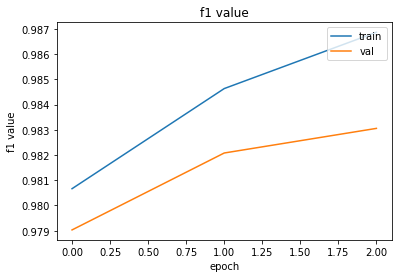

In [83]:
import matplotlib.pyplot as plt
plt.plot([i.cpu() for i in f1s])
plt.plot([i.cpu() for i in f1s_eval])
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Мы поменяли learning rate и добавили дропаут, кажется, стало лучше

Для анализа ошибок можно посмотреть на те примеры, которые мы (не)правильно предсказываем

In [228]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
                text = ''.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

In [229]:
fp, fn, tp, tn = predict(model, val_iterator)

In [230]:
print('что правильно предсказываем:', tp[:100])

что правильно предсказываем: ['даонионидумаличтомыиправдатакиенасамомтоделевсевсенормально', 'rtнезадаютэтобесплатныйсайтличноотебечтомы', 'rtедуввокругтакая', 'rtпозвонилавыздоравливай', 'недостаточноатемаобъяснилэточтоуменядрузьянепо', 'воченьнебольшойив', 'rtтакидедуанапочтеотдельныйящикраньшетак', 'поздравляювассднемделаюисполнения', 'rtспокойнойванв', 'ятолькохотелутебякактыпопалввсвободныйот', 'ябезумноусталазасегодняшниймоимроднымзаэтотвечер!', 'такбыисъел', 'ещенукакзато', 'какжеячтонекоторыелюдибылинамоемсулыбкой', 'сижуввдетскомтеатре—братдевушкииграетсразу2', 'дачтобктебепришел', 'rtтымнеяведьведусебякактебенравятсятольковтвоём', 'акаквышлидумалисбудетскучноинектонемыглубоко', 'когдабабушказаходитвавтобусвсявнезапно', 'собрал', 'какзафотовинстаграмспасибо', 'ивамтоженастроенияещё', 'завтраквпостель2ссыромичашкачерногочаялучшее', 'кпредыдущемууменяестьдрузьястакчтонаихужепримеремогу', 'rtсднембудешь', 'выкакаявыключаювнавсякиймалоли', 'янекогдатыговоришь//теперь', 'наувиделиу

In [231]:
print('ошибочно не относим к фамилиям:', fn[:100])

ошибочно не относим к фамилиям: ['меняужебеситтвоетупоесвоипринципыпрекратисратьвдушуатоубиратьзатобойбудеттолькотвоя', 'атокаквсечтонужноивточтоне', 'имя17минвкуснаякурица', 'какойсамыйкрутойзачет', 'нельзяживотнымахотелось', 'проспала15чувствуюсебясамымчеловекомна', '', 'ярешилазабитьнамодныесейчассериалыиначаласмотретьссамоготакподнимают', 'почемумолодымлюдямтакненравитсяженскаяобувь', 'rtнуещенеанастроениеуже', 'rtпотокскомпасмузыкойнааоттудачерезнаушникио_о', 'чтоэтозафотографии', 'есликвамсночевкоймногоивамнегдеихвозьмитепобольшеионисаминайдутсебе', 'насамомделеявшокес', 'менясилавзрывэмоций', 'чтояменявсегоипоканечтосигаретуменяпздц', 'утебяочэтоточно!', 'ядавнохотелимнонеполучитсялиачегонео_о', 'телефонненадо?а—ахахахах', 'оооообылоавбылилишь', 'ударвчелюстьзаменяет3часаэтопровмнетаклегче', 'забытьвыбывасхотябы', 'даточно', 'нущитонепросто', 'rtкрасиваялюблюпольшу', 'пиздецменяаааподпеснилюбимойнезряжзачеткаколятут', 'нувсезимниеканикулымнеспасибо', 'смотрюнаэтихдураковиузнаюна

In [232]:
print('ошибочно считаем фамилиями:', fp[:100])

ошибочно считаем фамилиями: ['rtвжопе', 'rtзабылаотметитьмойденьрождения29октября', 'янесигратормозитжутко—компне', 'rtnew–дрочунанее', 'ясебеоченьплохотакчтодавайлучшезавтрапойдемвсегулятьиятебетвой', 'теперьуменяестькрутаячтонемного', 'rtпочемутакойсерый—нравится', 'rtуменянапараллелитакаядевка', 'уменятакбарбиневернули', 'атакчтобывсёхорошо', 'яуедунакогдавырасту', 'rtвеликолепнаясериятолько', 'ятожеургантпро', 'почтине', 'ужемоскваспатьпошла', 'деньсвятоговсечтовсе', 'овоттебяитоприятнеемб', 'мнекупилиподарятеготолько29декабряждать15дней', 'пропустилнаминутунетеперьоколостоятьна', 'нунаучебехотяитыпосленгвсе-такиеще', 'надушемнепоможетивановнаиведроснимиибудет', 'япокастоювочередивбанкевсегдапомогаюотправитьпарунаниодинсотрудникбанкани', 'подарилинедавномненаодномдрнувеселаябылабез', 'сегодняпосмотрелднёмфильмнооченьинтереснаяреальная5из', 'чтокак/где/ненас', 'явообщепитьнадобыломеньше', 'да!какздоровоприйтиви38', 'напередчетыревсестоятвключая', 'толькочтоузналчтосегоднячто-то', 'ч